In [215]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [274]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')

# Chose which way you would like to use the dataset

In [277]:
# CHOSE HERE
'''
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/Cluster_4342/diabetes_data.csv'
'''

'''
# Or upload the csv file here
from google.colab import files
files.upload()
DATA_PATH = 'content/diabetes_data.csv'
'''
# Configuration
# Configuration

FEATURES = [
    'Age','Sex','HighChol','CholCheck','BMI','Smoker',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth',
    'DiffWalk','Stroke','HighBP'
]
OUTCOME_COL = 'Diabetes'
N_CLUSTERS = 2  # binary clustering
N_ROWS = 10000 # Due to RAM issues have to limit rows used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
# Load and preprocess
data = pd.read_csv(DATA_PATH, usecols=FEATURES + [OUTCOME_COL]).astype('float32')

#Randomize dataset and select only first 'N_ROWS' rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:N_ROWS]

In [220]:
#Feature matrix and labels
X_df = data[FEATURES].fillna(data[FEATURES].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y_true = data[OUTCOME_COL].values

In [221]:
# Determine optimal number of PCs via silhouette on KMeans
pc_scores = []
for n in range(2, min(X_scaled.shape[1], 11)):
    X_tmp = PCA(n_components=n, svd_solver='randomized', random_state=42).fit_transform(X_scaled)
    labels_tmp = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit_predict(X_tmp)
    sil_tmp = silhouette_score(X_tmp, labels_tmp)
    pc_scores.append((n, sil_tmp))
best_pc_n, best_pc_sil = max(pc_scores, key=lambda x: x[1])
print(f"Optimal PCA components: {best_pc_n} (Silhouette={best_pc_sil:.3f})")

Optimal PCA components: 2 (Silhouette=0.441)


In [222]:
# Apply PCA with chosen number of components
pca = PCA(n_components=best_pc_n, svd_solver='randomized', random_state=42)
X_reduced = pca.fit_transform(X_scaled)

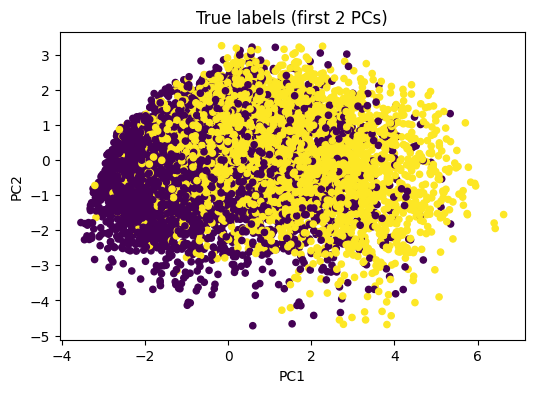

In [223]:
# Visualization: first two principal components
X_vis = X_reduced[:, :2]
plt.figure(figsize=(6,4))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_true, s=20)
plt.title('True labels (first 2 PCs)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

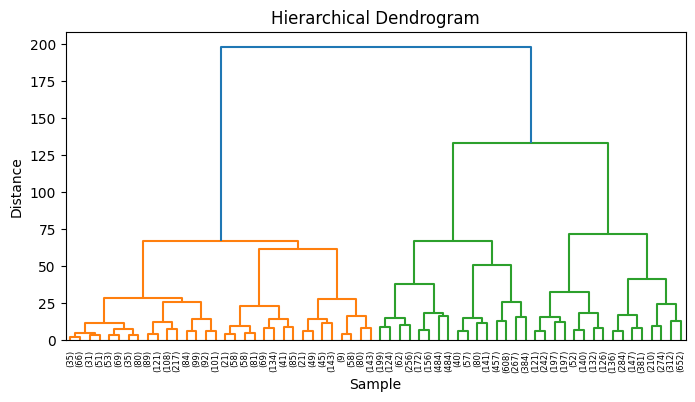

In [224]:
# Hierarchical clustering dendrogram
Z = linkage(X_reduced, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Dendrogram')
plt.xlabel('Sample'); plt.ylabel('Distance'); plt.show()

In [266]:
# Hierarchical hyperparameter tuning: linkage and metric
best_hc = {'sil': -np.inf, 'linkage': None, 'metric': None}
for link in ['ward', 'complete', 'average', 'single']:
    metrics = ['euclidean'] if link == 'ward' else ['euclidean', 'manhattan', 'cosine']
    for metric in metrics:
        model = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage=link, metric=metric)
        labels_hc = model.fit_predict(X_reduced)
        if len(set(labels_hc)) > 1:
            sil_hc = silhouette_score(X_reduced, labels_hc)
        else:
            sil_hc = np.nan
        if sil_hc > best_hc['sil']:
            best_hc.update({'sil': sil_hc, 'linkage': link, 'metric': metric})
print(f"Best Hierarchical: linkage={best_hc['linkage']}, metric={best_hc['metric']} (silhouette={best_hc['sil']:.3f})")


Best Hierarchical: linkage=average, metric=euclidean (silhouette=0.560)


In [267]:
# After A lot of testing these were the best parameters I could get with the time I had.
best_km_params = {'init': 'k-means++', 'algorithm': 'lloyd', 'n_init': 5, 'max_iter': 100}
best_hc_linkage = 'single'
best_db_params = {'eps': 0.7, 'min_samples': 2}
best_fcm_m = 100
best_gmm_params = {'covariance_type': 'spherical', 'reg_covar': 0.1}

# Define final clustering models with best‑found parameters
models = [
    ('KMeans', KMeans(
        n_clusters=N_CLUSTERS,
        init=best_km_params['init'],
        algorithm=best_km_params['algorithm'],
        n_init=best_km_params['n_init'],
        max_iter=best_km_params['max_iter'],
        random_state=42
    )),
    ('Hierarchical', AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        linkage=best_hc['linkage'],
        metric=best_hc['metric']
    )),
    ('DBSCAN', DBSCAN(
        eps=best_db_params['eps'],
        min_samples=best_db_params['min_samples']
    )),
    ('FuzzyCMeans', FCM(
        n_clusters=N_CLUSTERS,
        m=best_fcm_m
    )),
    ('GMM', GaussianMixture(
        n_components=N_CLUSTERS,
        covariance_type=best_gmm_params['covariance_type'],
        random_state=42,
        reg_covar=best_gmm_params['reg_covar']
    )),
    ('BIRCH', Birch(
        n_clusters=N_CLUSTERS
    ))
]

labels_store = {}

results = []

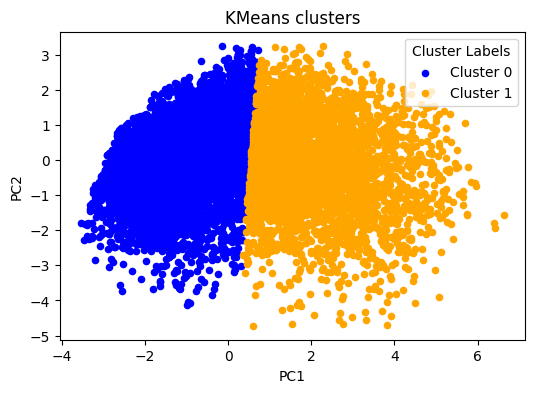

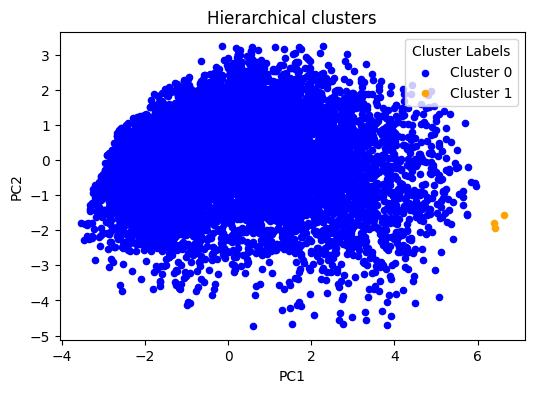

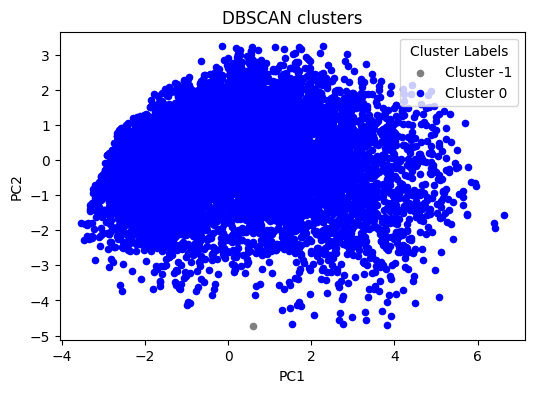

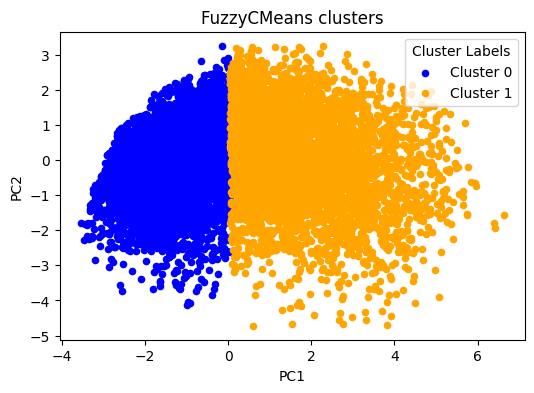

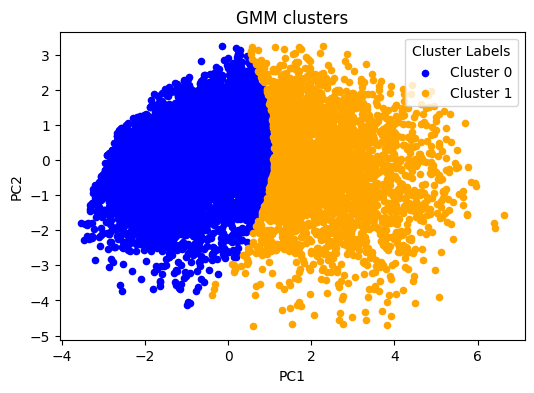

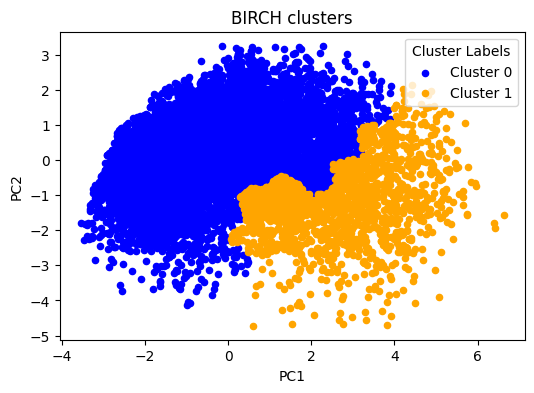

In [268]:
for name, model in models:
    # fit and predict, handle exceptions for FCM
    if name == 'FuzzyCMeans':
        try:
            model.fit(X_reduced)
            labels = model.u.argmax(axis=1)
        except Exception:
            labels = np.zeros(len(X_reduced), dtype=int)
    elif name == 'GMM':
        labels = model.fit_predict(X_reduced)
    else:
        labels = model.fit_predict(X_reduced)
    labels_store[name] = labels

    # visualization with explicit legend and fixed color mapping for clarity
    plt.figure(figsize=(6,4))
    color_map = {0: 'blue', 1: 'orange'}
    for cluster in np.unique(labels):
        plt.scatter(
            X_vis[labels == cluster, 0],
            X_vis[labels == cluster, 1],
            s=20,
            color=color_map.get(cluster, 'gray'),
            label=f'Cluster {cluster}'
        )
    plt.title(f'{name} clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster Labels')
    plt.show()

    # compute metrics, guard against single-label cases
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        sil = silhouette_score(X_reduced, labels)
        dbi = davies_bouldin_score(X_reduced, labels)
    else:
        sil = np.nan
        dbi = np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)

    results.append({
        'Algorithm': name,
        'Silhouette': sil,
        'Davies-Bouldin': dbi,
        'ARI': ari,
        'NMI': nmi
    })

# Evaluation Score
* Silhouette: -1 to 1, Closer to 1 the better
* Davies-Bouldin: 0 to infinity, closer to 0 the better
* ARI: -1 to 1, Closer to 1 the better
* NMI 0 to 1, Closer to 1 the better

In [269]:
# Display evaluation table
metrics_df = pd.DataFrame(results)
display(metrics_df)

,Algorithm,Silhouette,Davies-Bouldin,ARI,NMI
0,KMeans,0.440792,0.916533,0.115788,0.100362
1,Hierarchical,0.560053,0.311123,0.000010,0.000605
2,DBSCAN,0.449886,0.402315,-0.000003,0.000197
3,FuzzyCMeans,0.409951,0.964892,0.156100,0.119632
4,GMM,0.455027,0.894351,0.085531,0.085469
5,BIRCH,0.412003,0.900480,0.023269,0.039718


KMeans Confusion Matrix (counts):[[4216  823]
 [2475 2486]]


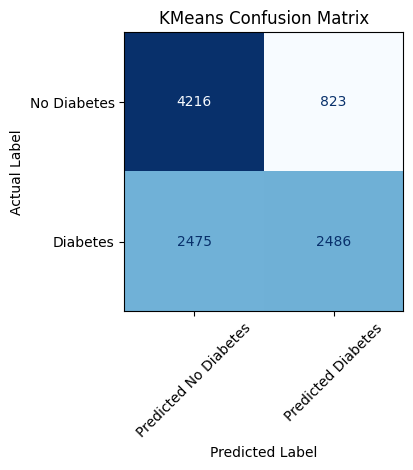

Hierarchical Confusion Matrix (counts):[[5039    0]
 [4958    3]]


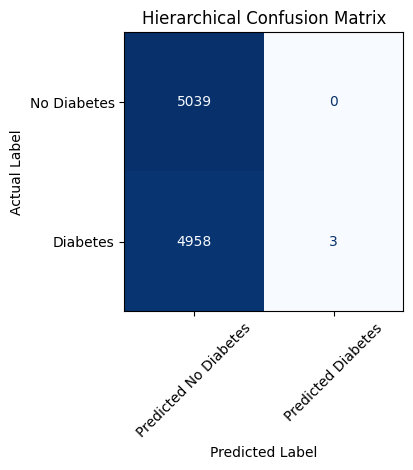

DBSCAN Confusion Matrix (counts):[[   0    0]
 [   1 5038]]


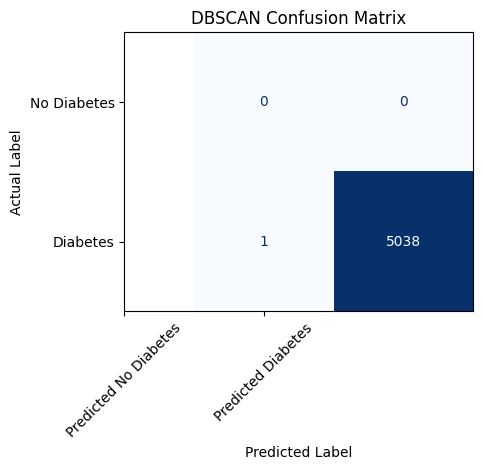

FuzzyCMeans Confusion Matrix (counts):[[3910 1129]
 [1895 3066]]


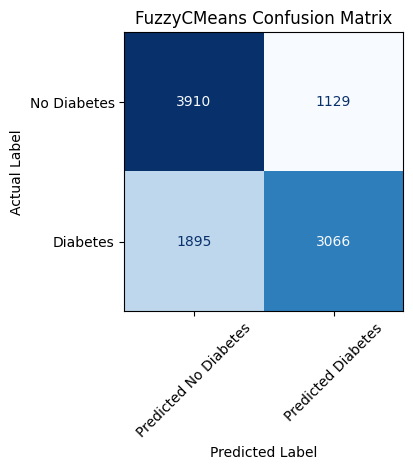

GMM Confusion Matrix (counts):[[4387  652]
 [2885 2076]]


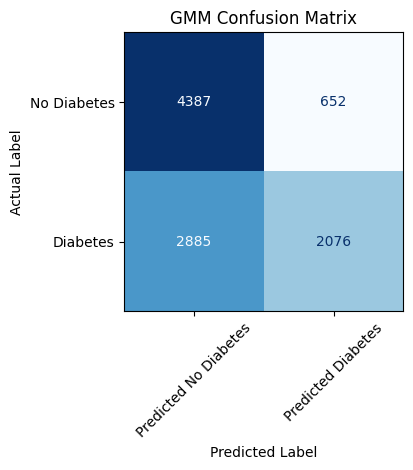

BIRCH Confusion Matrix (counts):[[4655  384]
 [3852 1109]]


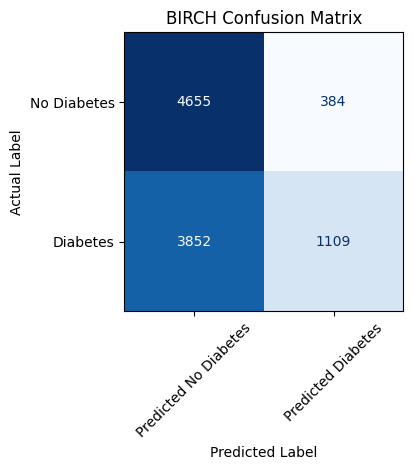

In [270]:
# Confusion matrices with dynamic labels
for name, labels in labels_store.items():
    unique_preds = np.unique(labels)
    unique_truth = np.unique(y_true)
    cm = confusion_matrix(y_true, labels, labels=unique_preds)
    print(f"{name} Confusion Matrix (counts):{cm}")
    # choose predicted labels display
    if len(unique_preds) == 2:
        pred_labels = ['Predicted No Diabetes','Predicted Diabetes']
    else:
        pred_labels = [f'Cluster {int(l)}' for l in unique_preds]
    # actual labels always two classes
    true_labels = ['No Diabetes','Diabetes']
    # plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_labels)
    disp.plot(cmap='Blues', colorbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.xticks(unique_preds, pred_labels, rotation=45)
    plt.yticks(unique_truth, true_labels)
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [271]:
# Cluster centroids and sizes in PC space (with meaningful cluster names)
features_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(best_pc_n)])
for name, labels in labels_store.items():
    if name == 'DBSCAN':
        continue
    # build DataFrame with true labels and cluster labels
    temp_df = features_df.copy()
    temp_df['cluster_label'] = labels
    temp_df['actual'] = y_true
    # determine cluster name by majority actual label
    label_mapping = {}
    for cluster in temp_df['cluster_label'].unique():
        majority = temp_df[temp_df['cluster_label']==cluster]['actual'].mode()[0]
        # assign human-readable name
        if majority == 0:
            label_mapping[cluster] = 'Predicted No Diabetes Cluster'
        else:
            label_mapping[cluster] = 'Predicted Diabetes Cluster'
    # compute centroids and sizes
    summary = temp_df.groupby('cluster_label').mean()[[f'PC{i+1}' for i in range(best_pc_n)]]
    summary['size'] = temp_df.groupby('cluster_label').size()
    # rename index using label_mapping
    summary.index = [label_mapping[idx] for idx in summary.index]
    print(f"{name} centroids and sizes (in PC space):")
    display(summary.round(2))

KMeans centroids and sizes (in PC space):


,PC1,PC2,size
Predicted No Diabetes Cluster,-1.05,0.08,6691
Predicted Diabetes Cluster,2.12,-0.16,3309


Hierarchical centroids and sizes (in PC space):


,PC1,PC2,size
Predicted No Diabetes Cluster,-0.00,0.00,9997
Predicted Diabetes Cluster,6.48,-1.77,3


FuzzyCMeans centroids and sizes (in PC space):


,PC1,PC2,size
Predicted No Diabetes Cluster,-1.25,-0.01,5805
Predicted Diabetes Cluster,1.74,0.02,4195


GMM centroids and sizes (in PC space):


,PC1,PC2,size
Predicted No Diabetes Cluster,-0.9,0.09,7272
Predicted Diabetes Cluster,2.4,-0.24,2728


BIRCH centroids and sizes (in PC space):


,PC1,PC2,size
Predicted No Diabetes Cluster,-0.47,0.21,8507
Predicted Diabetes Cluster,2.70,-1.21,1493


In [272]:
# Recommendations based on results
best_int = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'Algorithm']
best_ext = metrics_df.loc[metrics_df['ARI'].idxmax(), 'Algorithm']
print(f"Best internal algorithm: {best_int}")
print(f"Best external algorithm: {best_ext}")

Best internal algorithm: Hierarchical
Best external algorithm: FuzzyCMeans
